In [2]:

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import jieba
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier 
from sklearn.metrics import f1_score

字段	说明
ID	加密后的ID 

Age	0：未知年龄; 1：0-18岁; 2：19-23岁; 3：24-30岁; 4：31-40岁; 5：41-50岁; 6： 51-999岁

Gender	0：未知1：男性2：女性

Education	0：未知学历; 1：博士; 2：硕士; 3：大学生; 4：高中; 5：初中; 6：小学

Query List	搜索词列表


In [ ]:
data_source = "./data/"
train_ori = pd.read_csv(data_source+"train.csv", sep="###__###",header = None,encoding="utf-8")
train_ori.columns = ['ID', 'Age', 'Gender', 'Education', 'Query_List']
test_ori = pd.read_csv(data_source+"test.csv", sep="###__###",header = None,encoding="utf-8")
test_ori.columns = ['ID', 'Query_List']
##  todo list  网址处理
#regular1 = re.compile(r'[a-zA-Z]+://[^\s]*[.com|.cn]*')
#将网址和 拆分开来
#regular1 = re.compile(r'(http)(s?)(://)')  ###   match http 
#regular1 = re.compile(r'^((https|http|ftp|rtsp|mms)?:\/\/)[^\s]+')
#regular2 = re.compile(r'/([a-z].)[^\s]*')
#train_ori["Query"] = train_ori["Query"].apply(lambda x : re.sub(regular2," ",x))
train_ori["Query"] = train_ori["Query_List"].apply(lambda x : x.replace("\t"," "))
test_ori["Query"]= train_ori["Query_List"].apply(lambda x : x.replace("\t"," "))
stopwords=pd.read_csv("./stopwords.txt",index_col=False,quoting=3,sep="\t",names=['stopword'], encoding='utf-8')
stopwords=stopwords['stopword'].values
def drop_stopwords(content):
    try:
        segs=jieba.lcut(content)
        # 去标点、停用词等
        segs = list(filter(lambda x:len(x)>1, segs))
        segs = list(filter(lambda x:x not in stopwords, segs))
        # 将句子处理成  __label__1 词语 词语 词语 ……的形式
        #sentences.append("__label__"+str(category)+" , "+" ".join(segs))
    except Exception as e:
        print(line)
    return " ".join(segs)
train_ori["Query"] = train_ori["Query"].apply(lambda x : drop_stopwords(x))
train_data = train_ori[["Education","Query"]]
test_ori["Query"] = test_ori["Query"].apply(lambda x : drop_stopwords(x))
test_data = test_ori
train_save_file="./processed_data/train_data.csv"
train_ori.to_csv(train_save_file)
test_save_file="./processed_data/test_data.csv"
test_ori.to_csv(test_save_file)


#  TEXTCNN

In [3]:
###  高清楚数据流向！！！ 



import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import jieba
import re

saved_file="./processed_data/train_data.csv"
train_data = pd.read_csv(saved_file)
#test_saved_file="./processed_data/test_data.csv"
#test_data = pd.read_csv(test_saved_file)

## word2vec tfidf training

In [ ]:
print("writing data to fasttext format...")
out = open('./processed_data/train_data.txt', 'w', encoding='utf-8')
for sentence in sentences[:95000]:
    out.write(sentence+"\n")
out.close()
test=open('./processed_data/test_data.txt', 'w', encoding='utf-8')
for sentence in sentences[95000:]:
    test.write(sentence+"\n")
test.close()
print("done!")

In [ ]:
#tfidf 
#tfidf = TfidfVectorizer(ngram_range=(1,3), max_features=3000)
#train_test = tfidf.fit_transform(train_data["Query"][:10000])

#word2vec 
## 1 gensim
#from gensim.models.word2vec import Word2Vec

#num_features = 100     # Word vector dimensionality
#num_workers = 3       # Number of threads to run in parallel

#train_texts = train_data["Query"]
#model = Word2Vec(train_texts, workers=num_workers, size=num_features)
#model.init_sims(replace=True)

# save model
#model.save("./word2vec.bin")
#这个应用还有些问题

In [30]:
## 构建词映射

## vocab
from collections import Counter
import numpy as np

def build_vocab(train_data,vocab_file,vocab_size=5000):
    contents =[]
    for td in train_data:
        contents.extend(td.strip().split(' ') )
    print("contents",contents[:10])
    counter = Counter(contents)
    count_pairs = counter.most_common(vocab_size - 1)
    words, _ = list(zip(*count_pairs))
    # 添加一个 <PAD> 来将所有文本pad为同一长度
    words = ['<PAD>'] + list(words)
    print(words[:10])
    f = open(vocab_file, mode='w')
    f.write('\n'.join(words) + '\n')
    f.close()
# 这里面vocab size 不好确定
build_vocab(train_data["Query"],"processed_data/vocab.txt",vocab_size=1000000)

contents ['柔和', '双沟', '女生', '中财网', '首页', '财经', 'http', 'pan', 'baidu', '1plpjtn9']
['<PAD>', '图片', '手机', '小说', '视频', '下载', '大全', 'qq', '电影', '中国']


In [31]:
vocab_file = "processed_data/vocab.txt"
with open(vocab_file) as fp:
    words = [_.strip() for _ in fp.readlines()]
    word_to_id = dict(zip(words, range(len(words))))

In [34]:
def encode_cate(content, words):
    """将id表示的内容转换为文字"""
    return [(words[x] if x in words else 1000000) for x in content]

def encode_sentences(contents, words):
    """将id表示的内容转换为文字"""
    return [encode_cate(x,words) for x in contents]

In [48]:
from tensorflow.keras.utils import to_categorical
gender =[0,1,2]
#x_train = encode_sentences([content.strip().split(" ") for content in train_data["Query"]],word_to_id)
#y_train = to_categorical(encode_cate(train_data["Gender"],gender))
x_train = encode_sentences([content.strip().split(" ") for content in train_data["Query"][:10000]],word_to_id)
y_train = to_categorical(encode_cate(train_data["Gender"][:10000],gender))
x_test = encode_sentences([content.strip().split(" ") for content in train_data["Query"][-5000:]],word_to_id)
y_test = to_categorical(encode_cate(train_data["Gender"][-5000:],gender))


In [56]:
len(x_train[0])

100

In [57]:
##  textCNN
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout

class TextCNN(object):
    def __init__(self, maxlen, max_features, embedding_dims,
                 class_num=3,
                 last_activation='softmax'):
        self.maxlen = maxlen
        self.max_features = max_features
        self.embedding_dims = embedding_dims
        self.class_num = class_num
        self.last_activation = last_activation

    def get_model(self):
        input = Input((self.maxlen,))
        embedding = Embedding(self.max_features, self.embedding_dims, input_length=self.maxlen)(input)
        convs = []
        for kernel_size in [3, 4, 5]:
            c = Conv1D(128, kernel_size, activation='relu')(embedding)
            c = GlobalMaxPooling1D()(c)
            convs.append(c)
        x = Concatenate()(convs)

        output = Dense(self.class_num, activation=self.last_activation)(x)
        model = Model(inputs=input, outputs=output)
        return model


In [59]:
from tensorflow.keras.preprocessing import sequence
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
# 神经网络配置
max_features = 1000001
maxlen = 100
batch_size = 64
embedding_dims = 50
epochs = 8
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

print('构建模型...')
model = TextCNN(maxlen, max_features, embedding_dims).get_model()
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

print('训练...')
# 设定callbacks回调函数
my_callbacks = [
    ModelCheckpoint('./cnn_model.h5', verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=2, mode='max')
]
# fit拟合数据
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=my_callbacks,
          validation_data=(x_test, y_test))

#print('对测试集预测...')
#result = model.predict(x_test)
 

构建模型...
训练...
Train on 10000 samples, validate on 5000 samples
Epoch 1/8
 9984/10000 [============================>.] - ETA: 0s - loss: 0.7272 - accuracy: 0.6408
Epoch 00001: saving model to ./cnn_model.h5
10000/10000 [==============================] - 167s 17ms/sample - loss: 0.7267 - accuracy: 0.6411 - val_loss: 0.5837 - val_accuracy: 0.7446
Epoch 2/8
 9984/10000 [============================>.] - ETA: 0s - loss: 0.4638 - accuracy: 0.8359
Epoch 00002: saving model to ./cnn_model.h5
10000/10000 [==============================] - 160s 16ms/sample - loss: 0.4638 - accuracy: 0.8356 - val_loss: 0.5758 - val_accuracy: 0.7606
Epoch 3/8
 9984/10000 [============================>.] - ETA: 0s - loss: 0.1848 - accuracy: 0.9491
Epoch 00003: saving model to ./cnn_model.h5
10000/10000 [==============================] - 170s 17ms/sample - loss: 0.1848 - accuracy: 0.9491 - val_loss: 0.7446 - val_accuracy: 0.7364
Epoch 4/8
 9984/10000 [============================>.] - ETA: 0s - loss: 0.0683 - accura

In [60]:
print('对测试集预测...')
result = model.predict(x_test)

对测试集预测...


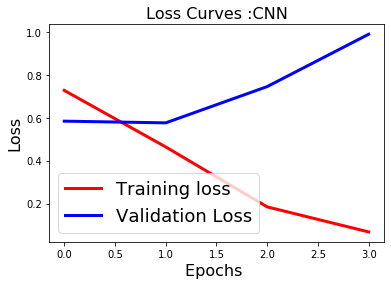

In [63]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()
